# Madison Real Estate Data Analysis

This notebook will walk you through the data wrangling, analysis, and basic visualizations of some trends in the City of Madison Real Estate market. Real esate sales data was scraped from [assessor's website](https://www.cityofmadison.com/assessor/property/salesbyarea.cfm) and date back to January 2002. More detailed property information was downloaded from the City of Madison [data portal](https://data-cityofmadison.opendata.arcgis.com/datasets/tax-parcels-assessor-property-information).

## 0: Initial questions
I've got some questions about the Madison Real Estate market that I want to answer.
* What does the housing market look like in different parts of Madison?
* How did the housing bubble of 2006 and the market crash of 2008 impact the Madison housing market?
* Do factors like location, style, or size, or type exhibit different market behavior or does the whole market move together?
* What does the housing market supply look like over time?
* Are the price differences between different housing options?
* Can we update the static annual property tax assessment data with recent home sales data to get an idea of what the market is doing now?
* How accurately can we project the 2018 housing market using past data?

In [2]:
import pandas as pd
import numpy as np
import datetime

import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## 1: Data Overview

### Assessor's Property Tax Data

Let's start by examining the columns of the property tax data, which are in the first line of the file:

In [3]:
tax_file_name = 'Tax_Parcels_Assessor_Property_Information.csv'

with open(tax_file_name,'r') as f:
    print(f.readline().count(',') + 1) # number of columns

147


Ok, so we have a fair number of data columns! Lets try to sort these 147 columns into categories and get at the characteristics we actually want to use in our model. Using all 147 of the columns to model home values would might lead to over fitting. Some of them contain duplicate data as well.

We can procedurally separate the columns into three analysis categories: identifying, mapping, continuous, and categorical/discrete variables. Identifiers are unique to each entry (such as `Address`). Mapping variables provide physical locations and shapes for mapping. Categorical variables are strings (`FrontageStreet`), have relatively few unique possibilities (`StreetNoise`), or are geographically clustered (`PoliceSector`). Continuous variables will have a large number of possible values, but each value won't necessarily be unique (`TotalLivingArea`).

In [4]:
df_tax = pd.read_csv(tax_file_name, index_col=1, low_memory=False)
all_tax_columns = df_tax.columns

In [5]:
ID_col = []; date_col = []; map_col = []; cont_col = []; cat_col = []; unsure = []; zoning = []; school = []
for col in df_tax.columns:
    count = df_tax[col].unique().shape[0]
    if 'Date' in col:
        date_col.append(col)
    elif 'Zoning' in col:
        zoning.append(col)
    elif 'School' in col:
        school.append(col)
    elif count > 70000:
        ID_col.append(col)
    elif count > 40000:
        map_col.append(col)
    elif count > 20 and df_tax[col].dtype == 'object':
        unsure.append(col)
    elif count < 275 or df_tax[col].dtype == 'object':
        cat_col.append(col)
    else:
        cont_col.append(col)
        
col_list_dict = {"ID" : ID_col, "Dates" : date_col, "Mapping" : map_col,
                 "Continuous" : cont_col, "Catigorical" : cat_col,
                 "Zoning" : zoning, "Schools" : school}
for key, value in col_list_dict.items():
    print(key,': ',value,'\n')
print('\n\nUnsure', unsure)

ID :  ['OBJECTID', 'Address'] 

Dates :  ['DateParcelChanged', 'AssessmentChangeDate', 'DateAdded', 'ObsoleteDate', 'OwnerChangeDate', 'ParcelChangeDate', 'PropertyChangeDate'] 

Mapping :  ['XRefParcel', 'XCoord', 'YCoord', 'SHAPESTArea', 'SHAPESTLength'] 

Continuous :  ['AssessmentArea', 'TotalLivingArea', 'FirstFloor', 'SecondFloor', 'ThirdFloor', 'AboveThirdFloor', 'FinishedAttic', 'Basement', 'FinishedBasement', 'CurrentLand', 'CurrentImpr', 'CurrentTotal', 'PreviousLand', 'PreviousImpr', 'PreviousTotal', 'NetTaxes', 'SpecialAssmnt', 'OtherCharges', 'TotalTaxes', 'LotSize', 'FrontageFeet', 'PreviousLand2', 'PreviousImpr2', 'PreviousTotal2', 'LotDepth', 'LotNumber', 'LotWidth', 'TifImpr', 'TifLand', 'TrafficAnalysisZone', 'HouseNbr', 'StreetID'] 

Catigorical :  ['PropertyClass', 'MoreThanOneBuild', 'HomeStyle', 'DwellingUnits', 'Stories', 'YearBuilt', 'Bedrooms', 'FullBaths', 'HalfBaths', 'ExteriorWall1', 'ExteriorWall2', 'Fireplaces', 'CentralAir', 'PartialAssessed', 'AssessedBy

In [6]:
# Basic Identifiers
basic = ['OBJECTID','Parcel','XRefParcel','Address','Unit','PropertyClass','PropertyUse','ParcelCode']
# Plotting
plotting = ['XCoord','YCoord','SHAPESTArea','SHAPESTLength']
# Assessor's values
tax_assessor = ['CurrentLand','CurrentImpr','CurrentTotal','PreviousLand',
                'PreviousImpr','PreviousTotal', 'PreviousLand2', 'PreviousImpr2',
                'PreviousTotal2','NetTaxes', 'SpecialAssmnt', 'OtherCharges', 'TotalTaxes',
                'TifImpr', 'TifLand', 'TifYear','PartialAssessed', 'AssessedByState',
                'ExemptionType','LotteryCredit']
# Building characteristics
build_info = ['MoreThanOneBuild','HomeStyle','DwellingUnits','TotalDwellingUnits',
              'Stories','YearBuilt','MaxConstructionYear',
              'Bedrooms','FullBaths','HalfBaths','TotalLivingArea',
              'FirstFloor','SecondFloor','ThirdFloor','AboveThirdFloor',
              'FinishedAttic','Basement','FinishedBasement','ExteriorWall1',
              'ExteriorWall2','Fireplaces','CentralAir','Landmark']

# Lot characteristics
lot_info = ['LotNumber','LotType1','LotType2','LotSize','LotWidth','LotDepth',
            'FrontageFeet','FrontageStreet','WaterFrontage','TypeWaterFrontage',
            'RailroadFrontage','WetlandInfo','Zoning1','Zoning2','Zoning3','Zoning4']

# Geographical divisions
geo_div = ['AssessmentArea','AreaName','RefuseDistrict','AlderDistrict',
           'CensusTract','TrafficAnalysisZone','TIFDistrict',
           'TaxSchoolDist','BuildingDistrict','CapitolFireDistrict',
           'ElectricalDistrict','EnvHealthDistrict','FireDistrict','HeatingDistrict',
           'NeighborhoodDesc','NeighborhoodPrimary','NeighborhoodSub',
           'NeighborhoodVuln','PlanningDistrict','PlumbingDistrict',
           'PoliceDistrict','PoliceSector','SenateDistrict','StormOutfall','SupervisorDistrict',
           'UrbanDesignDistrict','FireDemandZone','UWPolice','Ward', 'StateAssemblyDistrict','FireDemandSubZone']

# Schools:
school_info = ['AttendanceSchool','ElementarySchool','MiddleSchool','HighSchool']
# Location Info
loc_info = ['FloodPlain','FuelStorageProximity','LandfillProximity',
            'LandfillRemediation','LocalHistoricalDist','NationalHistoricalDist',
            'NoiseAirport','NoiseRailroad','NoiseStreet','ParkProximity']

toss = ['RefuseURL', 'BlockNumber','ZoningAll', 'ZoningBoardAppeal','PropertyUseCode','ConditionalUse', 'CouncilHold',
        'DeedPage', 'DeedRestriction', 'DeedVolume','IllegalLandDivision','HouseNbr', 'StreetDir',
        'StreetName', 'StreetType', 'StreetID', 'Holds', 'PreviousClass', 'ReasonChangeImpr', 'ReasonChangeLand',
        'LandscapeBuffer']

all_lists = basic + plotting + build_info + lot_info + geo_div + school_info + loc_info + tax_assessor + date_col + toss

leftover = [c for c in df_tax if c not in all_lists]
print(leftover)

['MCDCode', 'OwnerOccupied', 'Pending']


In [7]:
df_tax.LandscapeBuffer.describe()

count    79027.000000
mean         0.003961
std          0.062810
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: LandscapeBuffer, dtype: float64

We have a few of obvious mis-identified columns in this sort. First are `XRefParcel` and `LotNumber`, which is more of an identifier. `HouseNbr` and `StreetID` are both contained in the address, so they can be dropped entirely. Finally, `AssessmentArea` and `TrafficAnalysisZone` are geographic categorical features. Note that the remaining continuous variables are related to home size, lot size, and property taxes. To capture the home and lot characteristics with the fewest number of variables, we will use `TotalLivingArea`, `LotSize`, and `FrontageFeet`.

In [8]:
columns_to_drop = ['HouseNbr','StreetID','LotNumber']
try:
    ID_col.append('XRefParcel'); ID_col.append('LotNumber')
    map_col.remove('XRefParcel'); cont_col.remove('LotNumber')

    cont_col.remove('HouseNbr'); cont_col.remove('StreetID')
    cat_col.append('AssessmentArea'); cat_col.append('TrafficAnalysisZone')
    cont_col.remove('AssessmentArea'); cont_col.remove('TrafficAnalysisZone')
except ValueError:
    print('Error Dude')
model_columns = ['TotalLivingArea','LotSize','FrontageFeet']

Now that we have this sorted, lets remove all the non-residential properties from our dataframe, since we are only looking at residential property sales.

In [9]:
df_tax = df_tax[df_tax.PropertyClass == 'Residential'].drop('PropertyClass', 1)

In [10]:
# Basic Identifiers
basic = ['OBJECTID','Parcel','XRefParcel','Address','Unit','PropertyClass','PropertyUse']
# Plotting
plotting = ['XCoord','YCoord','SHAPESTArea','SHAPESTLength']
# Assessor's values
tax_assessor = ['CurrentLand','CurrentImpr','CurrentTotal','PreviousLand',
                'PreviousImpr','PreviousTotal', 'PreviousLand2', 'PreviousImpr2',
                'PreviousTotal2','NetTaxes', 'SpecialAssmnt', 'OtherCharges', 'TotalTaxes',
                'TifImpr', 'TifLand']
# Building characteristics
build_info = ['MoreThanOneBuild','HomeStyle','DwellingUnits','TotalDwellingUnits',
              'Stories','YearBuilt','MaxConstructionYear',
              'Bedrooms','FullBaths','HalfBaths','TotalLivingArea',
              'FirstFloor','SecondFloor','ThirdFloor','AboveThirdFloor',
              'FinishedAttic','Basement','FinishedBasement','ExteriorWall1',
              'ExteriorWall2','Fireplaces','CentralAir','Landmark']

# Lot characteristics
lot_info = ['LotNumber','LotType1','LotType2','LotSize','LotWidth','LotDepth',
            'FrontageFeet','FrontageStreet','WaterFrontage','TypeWaterFrontage',
            'RailroadFrontage','WetlandInfo','Zoning1','Zoning2','Zoning3','Zoning4']

# Geographical divisions
geo_div = ['AssessmentArea','AreaName','RefuseDistrict','AlderDistrict',
           'CensusTract','TrafficAnalysisZone','TIFDistrict',
           'TaxSchoolDist','BuildingDistrict','CapitolFireDistrict',
           'ElectricalDistrict','EnvHealthDistrict','FireDistrict','HeatingDistrict',
           'NeighborhoodDesc','NeighborhoodPrimary','NeighborhoodSub',
           'NeighborhoodVuln','PlanningDistrict','PlumbingDistrict',
           'PoliceDistrict','PoliceSector','SenateDistrict','StormOutfall','SupervisorDistrict',
           'UrbanDesignDistrict','FireDemandZone','UWPolice','Ward']
'''
#df = pd.read_csv(tax_file_name, index_col=1, usecols=basic+geo_div, dtype = 'str')
#df = df[df.PropertyClass == 'Residential'].drop('PropertyClass', 1)
#df.describe(include=['O']).iloc[1]

geo_div_coutns = df.describe(include=['O']).iloc[1]
good_counts = geo_div_coutns[geo_div_coutns > 50][geo_div_coutns <1000]
print(good_counts)
trial_geo_divs = good_counts.keys()

print(df[trial_geo_divs].describe(include=['O']))
'''

# Schools:
school_info = ['AttendanceSchool','ElementarySchool','MiddleSchool','HighSchool']
# Location Info
loc_info = ['FloodPlain','FuelStorageProximity','LandfillProximity',
            'LandfillRemediation','LocalHistoricalDist','NationalHistoricalDist',
            'NoiseAirport','NoiseRailroad','NoiseStreet','ParkProximity']
# Plotting info
plotting = ['XCoord','YCoord','SHAPESTArea','SHAPESTLength']

Our ID categories have thousands of entries (which makes sense) and many of our other geographic groupings have very few categories. Lets get rid of those columns and examine the intermediate ones.

### Property Sale Data
As stated before, this data was scraped from a website and was very ugly, with missing fields and inconsistent formating. I extracted only the Address, Price, Parcel, and Date and can get all the other data from joining the sales database with the property tax database.

In [11]:
sales_file_name = 'Sales.csv'
df_sales = pd.read_csv(sales_file_name, parse_dates = ['Date'])
df_sales.head()

,Address,Price,Parcel,Date
0,5207 Bliss St,155000,71034108219,2012-06-01
1,5207 Bliss St,192000,71034108219,2007-10-01
2,5225 Brandenburg Way,180000,71034107071,2007-07-01
3,5248 Brandenburg Way,193000,71034106106,2007-01-01
4,2317 Carling Dr,27000,60905214180,2012-11-01


Let's take a look at the sales data over time.

(array([730851.]), array([736664.]))

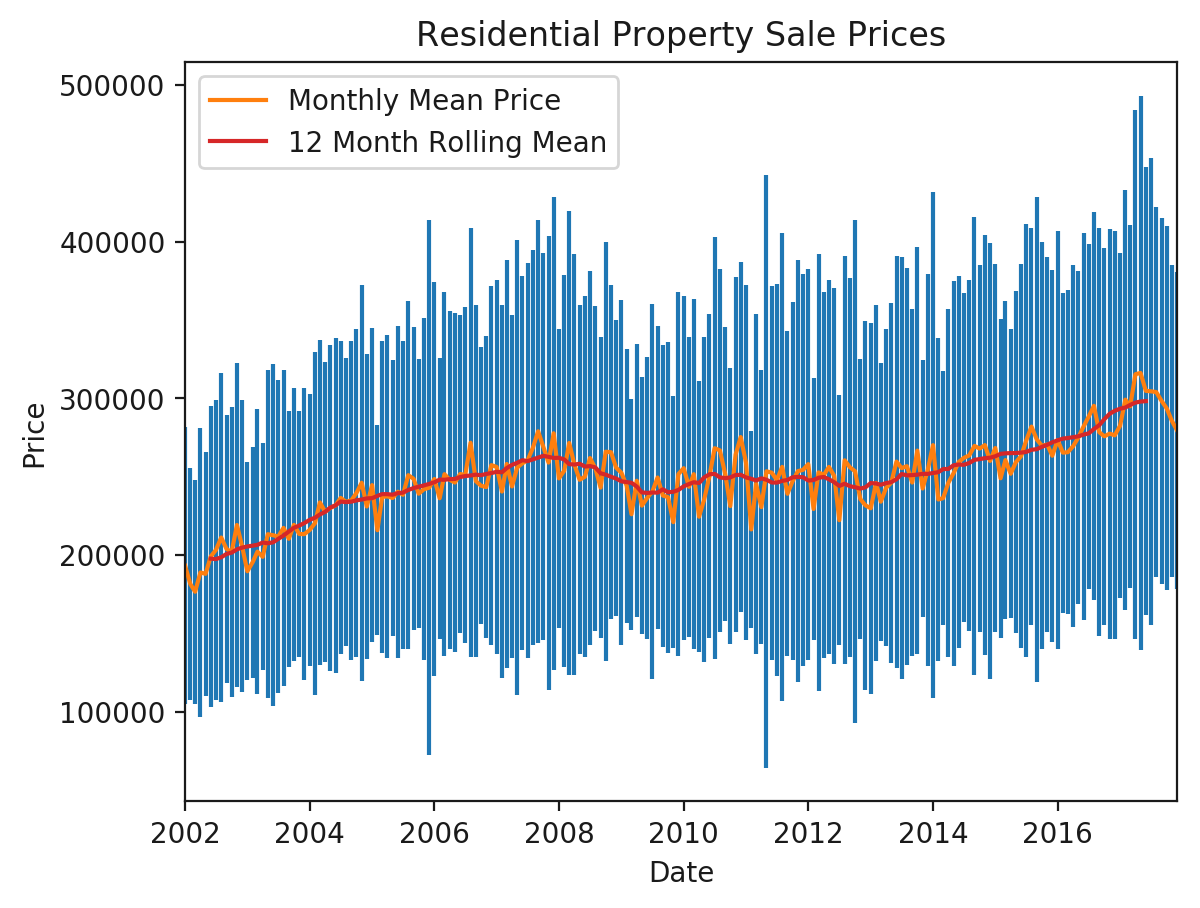

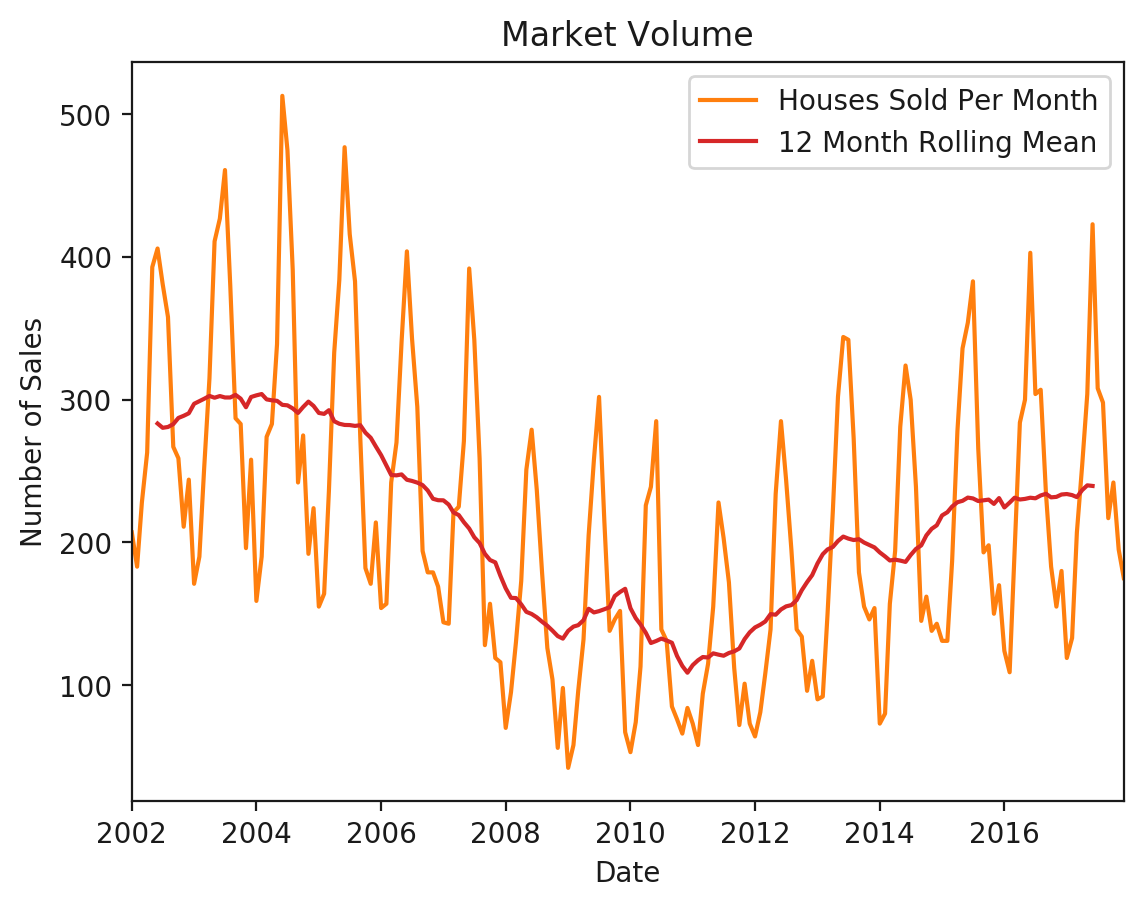

In [60]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

max_date = datetime.datetime.strptime('2018-01-01 00:00:00','%Y-%m-%d %H:%M:%S')
df_sales = df_sales[df_sales.Date < max_date]

# Data Workup
by_date = df_sales[df_sales.Date < max_date].groupby('Date')
means_by_date = by_date.mean()
rolling_means = running_mean(means_by_date.Price.values,12)
volume = by_date.count()
std_by_date = by_date.std()
dates = by_date.Date.unique()

### PLOTTING
# Price over time
plt.figure(dpi=200)
plt.errorbar(dates, means_by_date['Price'], yerr=std_by_date['Price'],
             marker='', linestyle='')
plt.plot(dates, means_by_date['Price'])
plt.plot(dates[5:-6], rolling_means, color='C3')
plt.legend(['Monthly Mean Price','12 Month Rolling Mean'], loc=2)
plt.ylabel('Price'); plt.xlabel('Date'); plt.title("Residential Property Sale Prices")
plt.xlim(min(dates),max(dates))

# Volume over time
plt.figure(dpi=200)
plt.plot(dates,volume['Price'], color='C1')
plt.plot(dates[5:-6],running_mean(volume['Price'].values,12), color='C3')
plt.legend(['Houses Sold Per Month','12 Month Rolling Mean'], loc=0)
plt.ylabel('Number of Sales'); plt.xlabel('Date'); plt.title("Market Volume")
plt.xlim(min(dates),max(dates))

In [13]:
np.average(volume['Price'])

213.56770833333334

We can see a a few very clear patterns in this market data. The market volume has large annual oscillations. By taking the 12-month rolling average, we can average out the annual oscillations to get a clearer picture of longer term market trends. We can clearly see the peak of the housing bubble in 2005 and subsequent market correction and crash in 2006 through 2008.

The annual periodicity is not as clear in the raw sales data. The larger trend also has some differences: residential unit prices trend upward until late 2007, the downturn is much less pronounced, and home prices have basically recovered by 2011. It might be tempting to conclude that the housing bubble didn't impact Madison home values like it did in the rest of the country. But before we jump to any conclusions, lets try to account for property type and quality, not just price.

## 2. Exploring Correlations
Now that we have some idea of what our datasets look like, let's take a bird's eye view of correlations between categories we think might be important. We've guessed at some important features, but a correlation map is a good idea.

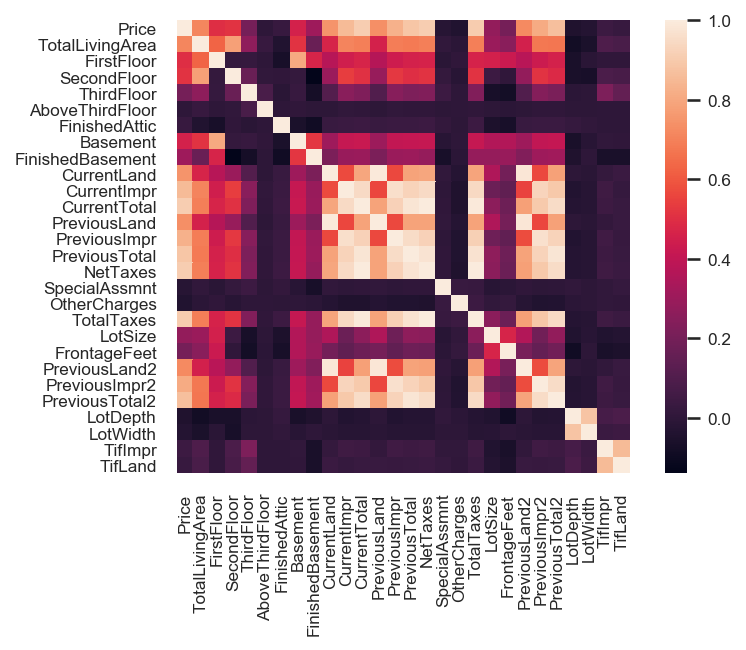

In [14]:
# Merge datasets
if 'Price' not in cont_col:
    cont_col = ['Price']+cont_col
df_sales = df_sales[df_sales.Date < max_date]

df = pd.merge(df_sales, df_tax, left_on = 'Parcel', right_index=True)

numerical = df[cont_col]
corr_mat = np.corrcoef(numerical.values.T)
sns.set(font_scale=.75)
plt.figure(dpi=150)
hm = sns.heatmap(corr_mat, cbar=True, annot=False, square=True,
                 fmt='.2f', yticklabels=cont_col, xticklabels=cont_col)
plt.show()

Unsurprisingly, the property tax assessor's value assessment is highly correlated to a home's sale value. But since we are trying to estimate the anticipated assessor value, lets remove these from our correlation matrix.

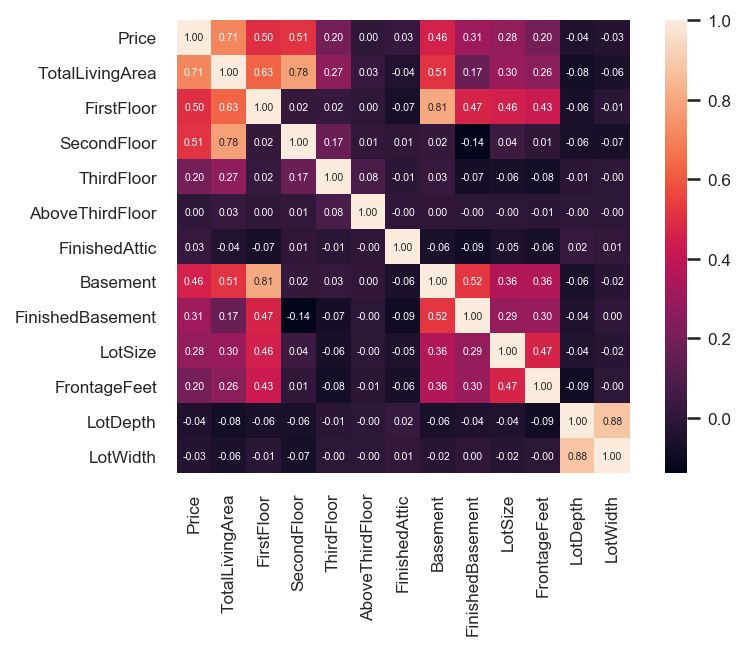

In [15]:
col = [c for c in cont_col if c not in tax_assessor]
numerical = df[col]
corr_mat = np.corrcoef(numerical.values.T)
sns.set(font_scale=.75)
plt.figure(dpi=150)
hm = sns.heatmap(corr_mat, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 5},
                 yticklabels=col, xticklabels=col)

The single best predictor of property value is `TotalLivingArea`, which is not surprising; price per square foot is a common metric for a reason. In fact, the top five features most correlated to `Price` are all measures of the size of the house. The area of the various floors are also correlated with the total livable square footage, but we should check if `TotalLivingArea` captures most of the variance in price.

Interestingly, `LotDepth` and `LotWidth` are not correlated with `LotSize` or `FrontageFeet`.  

So lets take another look at housing price over time, but this time using a new `PricePerSqFt` column.

39


C:\Users\Nina\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


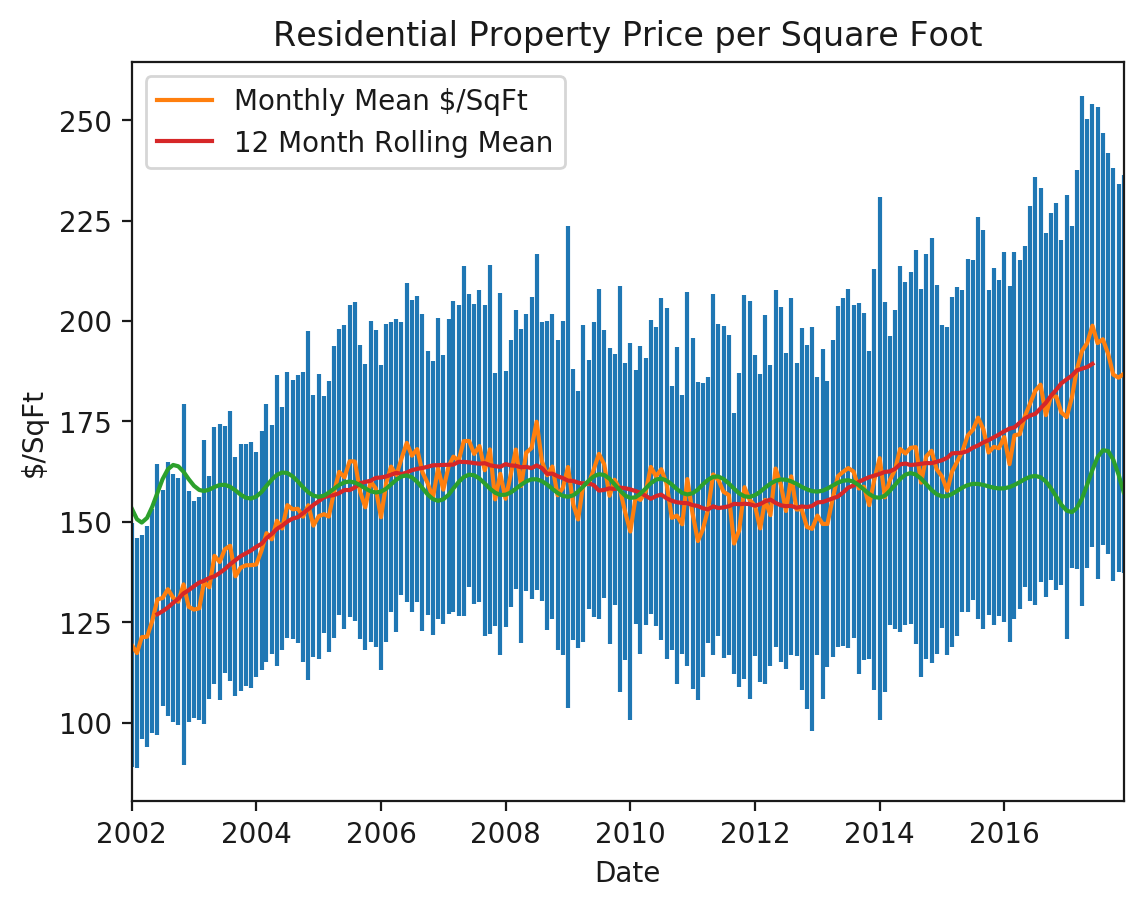

In [63]:
mpl.rcParams.update(mpl.rcParamsDefault)
# first remove any rows with no living space
print(df[df.PropertyUse == 'Condominium'].PropertyUse.count())
df = df[df.TotalLivingArea > 0]
df['PricePerSqFt'] = df.Price / df.TotalLivingArea

by_date = df[df.Date < max_date].groupby('Date')
ppsf_means_by_date = by_date.PricePerSqFt.mean()
ppsf_rolling_means = running_mean(ppsf_means_by_date.values,12)
ppsf_std_by_date = by_date.PricePerSqFt.std()
dates = by_date.Date.unique()

### PLOTTING
# Price/sqft over time
plt.figure(dpi=200)
plt.errorbar(dates, ppsf_means_by_date, yerr=ppsf_std_by_date,
             marker='', linestyle='')
plt.plot(dates, ppsf_means_by_date)
plt.plot(dates[5:-6], ppsf_rolling_means, color='C3')
plt.legend(['Monthly Mean $/SqFt','12 Month Rolling Mean'], loc=2)
plt.ylabel('$/SqFt'); plt.xlabel('Date'); plt.title("Residential Property Price per Square Foot")
plt.xlim(min(dates),max(dates))

fft_means = np.fft.fft(ppsf_means_by_date)
fft_means[1:10] = 0
fft_means[21:] = 0
ifft_means = np.fft.ifft(fft_means)
plt.plot(dates,ifft_means)

Now that we have a measure of how much house can be bought, we see the oscillations we observed in the volume data re-emerging.

In order to remove both the annual cycles and the overall trend from our home data, we can subtact the mean from our price per square foot data for each month.

We should also better characterize these oscillations by creating a month column so we can group by month.

In [17]:
zscore = lambda x: (x - x.mean()) / x.std()

df['PPSFzscore'] = df[['Date','PricePerSqFt']].groupby('Date').transform(zscore)['PricePerSqFt']

(730851.0, 736664.0)

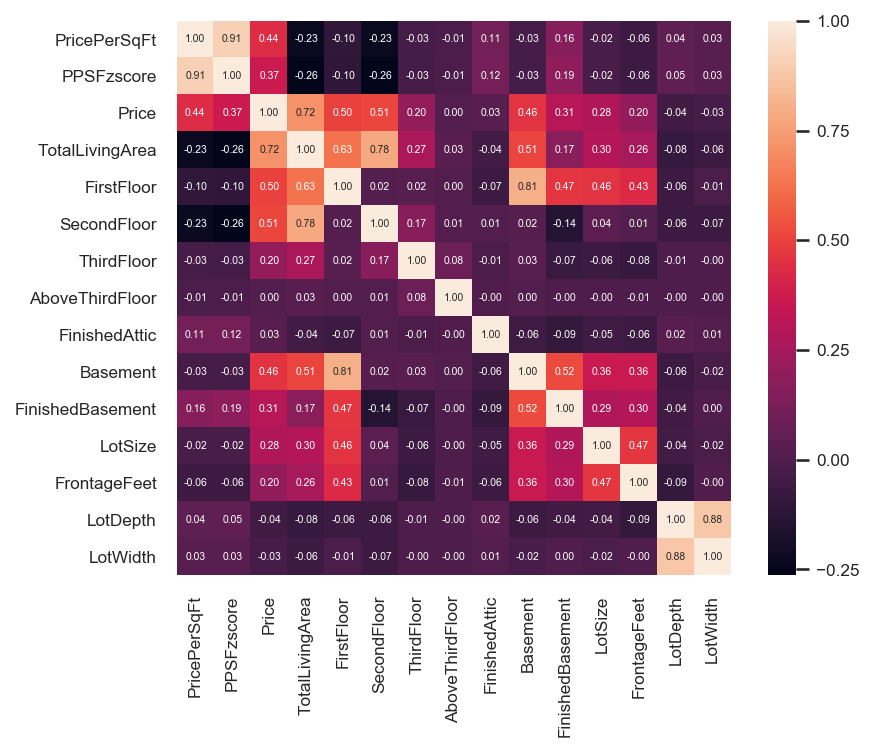

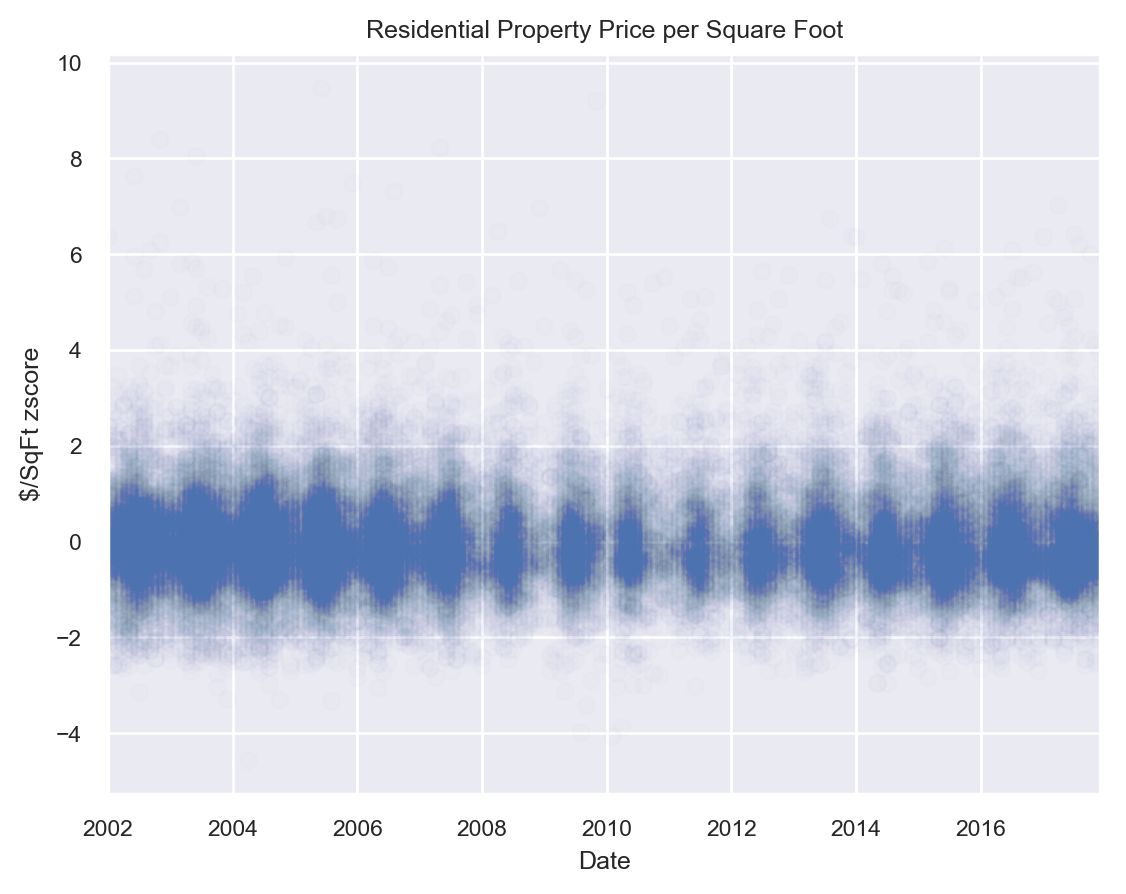

In [20]:
col = [c for c in cont_col if c not in tax_assessor]
col = ['PricePerSqFt','PPSFzscore'] + col
numerical = df[col]
corr_mat = np.corrcoef(numerical.values.T)
sns.set(font_scale=.75)
plt.figure(dpi=150)
hm = sns.heatmap(corr_mat, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 5},
                 yticklabels=col, xticklabels=col)

Our `PricePerSqFt` is now negatively correlated with `TotalLivingArea` and `SecondFloor`, but only slightly. We might want to revisit these, but for now, this seems to capture most of the linear behavior of the continuous variables.

This doesn't include the size or location of the lot, however. A reasonable neighborhood-level baseline model might be 
$$\alpha * LotSize + \beta * TotalLivingArea = Price$$

But before we start modeling, lets check out what our price per square foot distribution looks like.

39

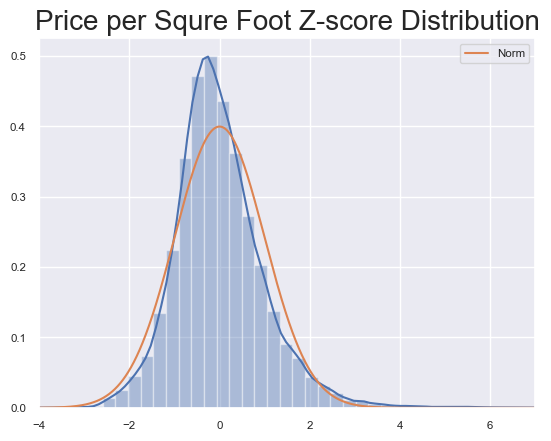

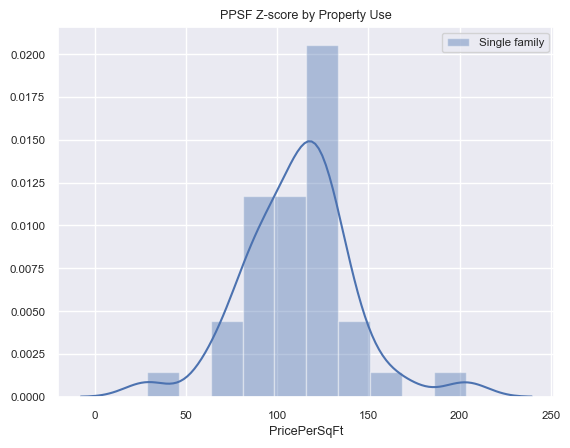

In [75]:
sns.distplot(df.PPSFzscore.values)
plt.title("Price per Squre Foot Z-score Distribution", size=20)

plt.xlim(-4,7)
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(df.PPSFzscore.values))

m, s = sp.stats.norm.fit(df.PPSFzscore.values) # get mean and standard deviation  
pdf_g = sp.stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it
plt.legend()
plt.savefig('ppsf.png')

plt.figure()
#legend = ['Single family','Condominium',"Multi Unit"]
#sns.distplot(df.loc[df.PropertyUse == 'Single family',('PPSFzscore')])
sns.distplot(df.loc[df.PropertyUse == 'Condominium',('PricePerSqFt')])
#sns.distplot(df[df.PropertyUse != 'Single family'][df.PropertyUse != 'Condominium'].PPSFzscore.values)
plt.legend(legend)
plt.title("PPSF Z-score by Property Use")
df[df.PropertyUse == 'Condominium'].PropertyUse.count()

While this is looks ok, it is clear there is some positive skew and quite a bit of kurtosis. Let's take a look at the high $/sq.ft. properties.

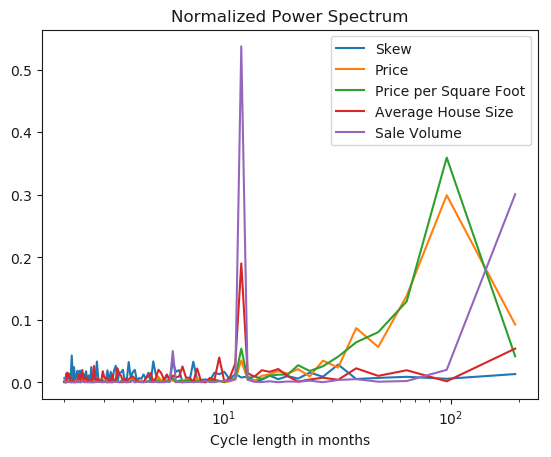

In [160]:
### skew of PPSFzscore over time
#by_date = df[df.Date < max_date].groupby('Date')
by_date = df.loc[df.Date < max_date].groupby('Date')

# wavelength = 1/frequency
# cycle_length = index/frequency
cycle_length = [len(dates)/i for i in range(1,len(dates)//2+1)]

monthly_skew = by_date['PPSFzscore'].apply(sp.stats.skew)

def plot_power(arr,**kwargs):
    a = np.fft.rfft(arr)[1:]
    spectrum = np.real(a*a.conj()/np.dot(a,a.conj()))
    plt.plot(cycle_length,spectrum,**kwargs) 

plt.figure()
plot_power(monthly_skew)
plot_power(means_by_date["Price"])
plot_power(ppsf_means_by_date)
plot_power(by_date["TotalLivingArea"].mean())
plot_power(volume['Price'])

plt.legend(['Skew','Price','Price per Square Foot',"Average House Size","Sale Volume"])
plt.title('Normalized Power Spectrum')
plt.xscale('log')
plt.xlabel('Cycle length in months')
#plt.xlim(min(cycle_length),26)
plt.savefig("Normalized Power Spectrum.png")

In [148]:
len(fft_ms[1:])

96

In [35]:
pd.apply(by_date['PPSFzscore']

Percent Water Frontage in Dataset: 0.74%
Percent Water Frontage in 3 sigma: 35.82%


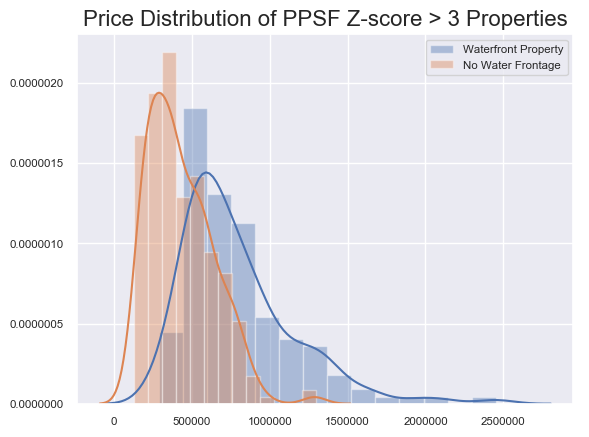

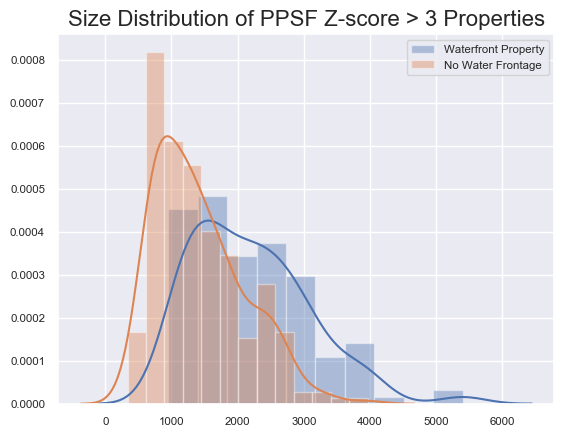

In [38]:
high_ppsf = df[df.PPSFzscore > 3]

percent_waterfrontage = df.WaterFrontage[df.WaterFrontage =='YES'].count()/df.WaterFrontage.count()*100
percent_waterfrontage_3sigma = high_ppsf.WaterFrontage[high_ppsf.WaterFrontage =='YES'].count()/high_ppsf.WaterFrontage.count()*100
s = "Percent Water Frontage in Dataset: {}%\nPercent Water Frontage in 3 sigma: {}%"
print(s.format(*np.round((percent_waterfrontage, percent_waterfrontage_3sigma),2)))


sns.distplot(high_ppsf[high_ppsf.WaterFrontage == 'YES'].Price.values)
sns.distplot(high_ppsf[high_ppsf.WaterFrontage == 'NO'].Price.values)
plt.legend(['Waterfront Property','No Water Frontage'])
plt.title('Price Distribution of PPSF Z-score > 3 Properties', size = 16)
plt.savefig('highppsfdist.png')

plt.figure()
sns.distplot(high_ppsf[high_ppsf.WaterFrontage == 'YES'].TotalLivingArea.values)
sns.distplot(high_ppsf[high_ppsf.WaterFrontage == 'NO'].TotalLivingArea.values)
plt.legend(['Waterfront Property','No Water Frontage'])
plt.title('Size Distribution of PPSF Z-score > 3 Properties', size = 16)
plt.savefig('highppsfdist.png')

In [ ]:
print(high_ppsf.WaterFrontage[high_ppsf.WaterFrontage =='YES'].count()/high_ppsf.WaterFrontage.count(),'\n')
print(df.WaterFrontage[df.WaterFrontage =='YES'].count()/df.WaterFrontage.count())

In [ ]:
from statsmodels.formula.api import ols

#model = ols("PPSFzscore ~ C(WaterFrontage) + C(ElementarySchool) + 1",df).fit()
#print(model.summary())

model = ols("Price ~ TotalLivingArea + C(WaterFrontage) + C(ElementarySchool) + 1",df).fit()
print(model.summary())

In [ ]:
sns.distplot(df.PricePerSqFt.values)
plt.title("Price per Squre Foot Distribution")
plt.savefig('ppsf.png')
plt.figure()
sns.distplot(df.PricePerSqFt.values)
plt.title("Price Distribution")
plt.savefig('price_dist.png')
plt.figure()
sns.distplot(df.PPSFzscore, bins = 500)

In [ ]:
#df[df.WaterFrontage == 'NO'][df.PPSFzscore > 4].PPSFzscore.count()/df[df.WaterFrontage == 'NO'].PPSFzscore.count()

## plot where the outliers are
plt.figure(dpi=200)
plt.scatter(df['XCoord'], df['YCoord'], marker='.', alpha = .01)

BoatToEat = df[df.WaterFrontage == 'YES']
plt.scatter(BoatToEat['XCoord'], BoatToEat['YCoord'], marker='.')

ToEat = df[df.WaterFrontage == 'NO'][df.PPSFzscore > 4]
plt.scatter(ToEat['XCoord'], ToEat['YCoord'], marker='.')

plt.savefig('Outliers.png')

In [ ]:
model = ols("PPSFzscore ~ C(WaterFrontage) + C(PropertyUse) + 1",df).fit()
print(model.summary())

In [ ]:
sns.distplot(ToEat['Price'])
plt.title("High $/sqft property price distribution")
plt.savefig("Highppsf.png")

## 3. Location, Location, Location!

Lets take a look at the different location features to determine which we want to use for our model building. Lets start with cheking out Elemnetary School as the defining neighborhood feature. But lets also look at home sales.

Because the home prices fluctuate over time, we can try to get a better handle on the relative home prices by using each home's z-score for each month, that is, the distance from the mean in standard deviations. We can then gauge the sale-date normalized home value.

However, to look at trends across neighborhoods, we will need to be careful about how many geographic categories are included. There are just over 200 home sales per month on average in our dataset. If we have more than ~20 geographic regions, we will probably have trouble seeing different trends in different neighborhoods (although a 12 month rolling average will help).

In [ ]:
# find the average, stdev for distances from center locaton, also for all of madison.

def distance_distribution(x1coords, x2coords):
    center = (np.average(x1coords), np.average(x2coords))
    distances = np.sqrt((center[0]-x1coords)**2 + (center[1]-x2coords)**2)
    return center, np.nanmean(distances), np.nanstd(distances)

centers = []
ave_dist = []
stds = []

nope = ['OwnerChangeDate','Holds','Unit','FrontageStreet','StreetName']

for idx, col in enumerate(geo_div):
    this_centers = []
    this_ave_dist = []
    this_std = []
    stop = col in nope or 'Date' in col
    if col in df_tax.columns and not stop:
        for value in df_tax[col].unique():
            group = df_tax[df_tax[col] == value]
            c,ad,sd = distance_distribution(group['XCoord'],group['YCoord'])
            this_centers.append(c)
            this_ave_dist.append(ad)
            this_std.append(sd)
    centers.append(this_centers)
    ave_dist.append(this_ave_dist)
    stds.append(this_std)

In [ ]:
%%time
Madison_center, Madison_avedist, Madison_diststd = distance_distribution(df_tax['XCoord'],df_tax['YCoord'])
print(Madison_center, Madison_avedist, Madison_diststd)

In [ ]:
number = [len(c) for c in centers]
mean_mean_dists = [np.nanmean(d) for d in dist_dist]
ave_std_dists = [np.nanmean(d) for d in dist_dist]

In [ ]:
sns.scatterplot('Price','PPSFzscore', data=df, hue='ElementarySchool',markers='.',fit_reg=False,)
plt.ylim((-4,10))

In [ ]:
for i in range(25):
    n = number[i]
    print('{}\t\t{}\t\t{}\t\t{}'.format(geo_div[i],n,mean_mean_dists[i],max(stds[i])))

In [ ]:
np.average(std_by_date/means_by_date)

In [88]:
df.PropertyUse.astype('category').values.categories

Index(['2 Unit', '2 unit Apartment', '3 unit Apartment', '4 unit Apartment',
       '5 unit Apartment', '6 unit Apartment', '7 unit Apartment',
       'Condominium', 'Other', 'Single family'],
      dtype='object')

## 4. Discrete and Categorical Features

In [97]:
df_tax.loc[70913320134].CurrentTotal

0

In [27]:
df['Month'] = df.Date.map(lambda x : x.month)